<a href="https://colab.research.google.com/github/zp20945/DSDM/blob/main/assignment/pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import PIL.Image as Image
from torchvision import datasets,models
import matplotlib.pyplot as plt
from torch.autograd import Variable
import warnings
warnings.filterwarnings("ignore")

In [72]:
!git clone https://github.com/zp20945/DSDM.git

fatal: destination path 'DSDM' already exists and is not an empty directory.


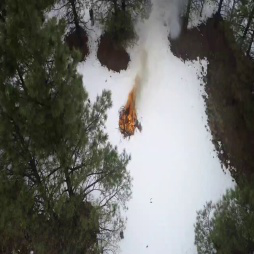

In [73]:
im=Image.open('/content/DSDM/assignment/Training/Fire/resized_frame0.jpg')
im

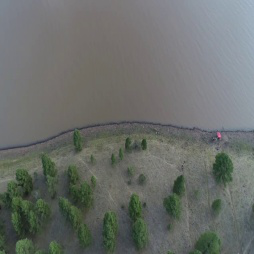

In [74]:
im2=Image.open('/content/DSDM/assignment/Training/No-Fire/lake_resized_lake_frame0.jpg')
im2

In [75]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

In [76]:
input_path='/content/DSDM/assignment'
data_image={
    'train': datasets.ImageFolder(input_path+'/Training/',data_transforms['train'])
    , 'test':datasets.ImageFolder(input_path+'/Test/',data_transforms['validation'])
       
}


In [77]:
train_loader=torch.utils.data.DataLoader(data_image['train'],
                                batch_size=1,
                                shuffle=True,
                                num_workers=0)

In [78]:
validation_loader=torch.utils.data.DataLoader(data_image['test'],
                                batch_size=1,
                                shuffle=True,
                                num_workers=0)

In [79]:
def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

training images
tensor(1)
torch.Size([3, 224, 224])


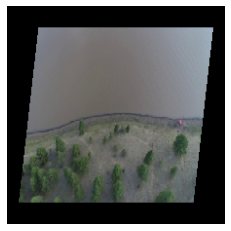

In [80]:
trainimages, trainlabels = next(iter(train_loader))

print('training images')

imshow(trainimages[0])
print(trainlabels[0])

print(trainimages[0].size())

In [81]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [82]:
# Creating the CNN neural network
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv1=nn.Conv2d(3,6,3)
        self.conv2=nn.Conv2d(6,16,3)
        self.f1=nn.Linear(16*54*54,2)     

    def forward(self,x):
        x=torch.tensor(x,dtype=self.conv1.weight.dtype)
        x=F.max_pool2d(self.conv1(x),(2,2))
        x=F.max_pool2d(self.conv2(x),2)
        x=x.view(-1,self.get_size(x))
        x=self.f1(x)
        return x
    def get_size(self,x):
        nn=1
        ps=x.size()[1:]
        for i in ps:
            nn*=i
        return nn

In [83]:
cnn=CNN()
cnn=cnn.to(device)

In [84]:
# Cross Entropy Loss  
error = nn.CrossEntropyLoss()

# SGD Optimizer 
learning_rate = 0.001
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)

In [85]:
batch_size=1
n_iters = 10000
num_epochs = n_iters / (8005 / batch_size)
num_epochs = int(num_epochs)

In [86]:
# Traning the Model
count = 0
loss_list = []
iteration_list = []
accuracy_list=[]
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Define variables
        train = Variable(images.view(1, 3,224,224)).to(device)
        labels = Variable(labels).to(device)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = cnn(train)
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Calculate gradients
        loss.backward()

        # Update parameters
        optimizer.step()
        
        count += 1
        
        # Prediction
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in validation_loader: 
                test = Variable(images.view(1,3,224,224)).to(device)
                labels=Variable(labels).to(device)
                
                # Forward propagation
                outputs = cnn(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)

                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            print('1')
        #if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {}%'.format(count, loss.data, accuracy))

1
Iteration: 50  Loss: 0.0  Accuracy: 50.0%
1
Iteration: 100  Loss: 0.0  Accuracy: 50.0%


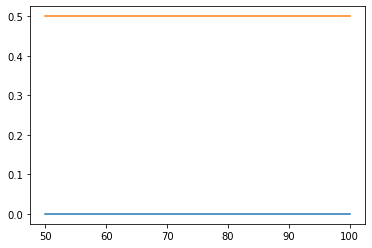

In [87]:
plt.plot(iteration_list,loss_list)
plt.plot(iteration_list,np.array(accuracy_list)/100)